In [1]:
def read_code_from_file(file_path: str) -> str:
    with open(file_path, "r") as file:
        code = file.read()
    return code


def write_code_to_file(file_path: str, code: str):
    with open(file_path, "w") as file:
        file.write(code)

In [2]:
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool

repl = PythonREPL()


@tool
def python_repl(code: Annotated[str, "filename to read the code from"]):
    """Use this to execute python code read from a file. If you want to see the output of a value,
    Make sure that you read the code from correctly
    you should print it out with `print(...)`. This is visible to the user."""

    try:
        result = repl.run(code)
        print("RESULT CODE EXECUTION:", result)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Executed:\n```python\n{code}\n```\nStdout: {result}"

In [3]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage


model = ChatOpenAI()
model_with_tools = model.bind_tools([python_repl])

In [4]:
messages = [
    SystemMessage(
        content=""" You have got the task to execute code. Use the pyhon_repl tool to execute it.
        If the code produced an error just return 'False'. If it worked, return 'True'"""
    ),
    HumanMessage(content="testscript.py"),
]

ai_msg = model_with_tools.invoke(messages)
messages.append(ai_msg)

In [5]:
messages

[SystemMessage(content=" You have got the task to execute code. Use the pyhon_repl tool to execute it.\n        If the code produced an error just return 'False'. If it worked, return 'True'"),
 HumanMessage(content='testscript.py'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_SfN2Z3lYMHbV74L9mkIEhUyS', 'function': {'arguments': '{"code":"with open(\'testscript.py\', \'r\') as file:\\n    script = file.read()\\n    exec(script)"}', 'name': 'python_repl'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 152, 'total_tokens': 191}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-844a0f06-cab9-41f6-9983-2f351598a4e2-0', tool_calls=[{'name': 'python_repl', 'args': {'code': "with open('testscript.py', 'r') as file:\n    script = file.read()\n    exec(script)"}, 'id': 'call_SfN2Z3lYMHbV74L9mkIEhUyS'}])]

In [6]:
from langchain_core.messages import HumanMessage, ToolMessage

for tool_call in ai_msg.tool_calls:
    selected_tool = {"python_repl": python_repl}[tool_call["name"].lower()]
    tool_output = selected_tool.invoke(tool_call["args"])
    messages.append(ToolMessage(tool_output, tool_call_id=tool_call["id"]))

model_with_tools.invoke(messages)

Python REPL can execute arbitrary code. Use with caution.


RESULT CODE EXECUTION: TypeError("unsupported operand type(s) for +: 'int' and 'str'")


AIMessage(content='False', response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 252, 'total_tokens': 254}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-0f6f3d0f-5e72-43ce-ae28-92e93d46c74f-0')

### Working with Agents

In [7]:
from typing import TypedDict


class AgentState(TypedDict):
    message: str
    error: bool
    error_message: str
    file_path: str
    code: str
    iterations: int

In [8]:
def identify_filepath(state: AgentState):
    message = state["message"]
    model = ChatOpenAI()
    messages = [
        SystemMessage(
            content="""Your task is to evaluate the userinput and extract the filename he provided.
                              ONLY return the last filename, nothing else!"""
        ),
        HumanMessage(content=message),
    ]
    result = model.invoke(messages)
    state["file_path"] = result.content
    return state


def execute_code_with_model(state: AgentState):

    code = read_code_from_file(state["file_path"])

    model = ChatOpenAI()
    model_with_tools = model.bind_tools([python_repl])

    messages = [
        SystemMessage(
            content=""" You have got the task to execute code. Use the python_repl tool to execute it. I will a message and your task is to detect if it was successfully run or produced an error.
            If the code produced an error just return 'True'. If it was sucessfully executed, return 'False'"""
        ),
        HumanMessage(content=code),
    ]

    ai_msg = model_with_tools.invoke(messages)
    messages.append(ai_msg)

    for tool_call in ai_msg.tool_calls:
        selected_tool = {"python_repl": python_repl}[tool_call["name"].lower()]
        tool_output = selected_tool.invoke(tool_call["args"])
        state["error_message"] = tool_output
        messages.append(ToolMessage(tool_output, tool_call_id=tool_call["id"]))

    result = model_with_tools.invoke(messages)
    print("EVALUATION RESULT:", result)
    state["error"] = result.content
    return state


def rewrite_code(state: AgentState):

    code = state["code"]
    error = state["error_message"]
    state["iterations"] += 1
    model = ChatOpenAI()
    messages = [
        SystemMessage(
            content="You can to analyze the following code and error provided in the usermessage. Your task is to fix that code and provide the user the correct new code. VERY IMPORTANT: ONLY RETURN THE UPDATED CODE, NOTHING ELSE! Dont use a markdown style, just the code as Text"
        ),
        HumanMessage(content=f"Code: {code} | Error: {error}"),
    ]
    ai_msg = model.invoke(messages)
    print("NEW SUGGESTED CODE:", ai_msg.content)
    write_code_to_file(file_path=f'{state["file_path"]}', code=ai_msg.content)
    state["code"] = ai_msg.content
    return state


def next_step(state: AgentState):
    if state["iterations"] > 3:
        print("Max Iterations done.... Exit Agent")
        return "max_iterations"
    if state["error"] == "True":
        print(f"Error in {state['file_path']}. {state['iterations']} tries done")
        return "error"
    if state["error"] == "False":
        print(
            f"Code was probably fixed... check out {state['file_path']} if it is correct"
        )
        return "ok"

In [9]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(AgentState)

workflow.add_node("identify_filepath", identify_filepath)
workflow.add_node("execute_code_with_model", execute_code_with_model)
workflow.add_node("rewrite_code", rewrite_code)

workflow.set_entry_point("identify_filepath")
workflow.add_edge("identify_filepath", "execute_code_with_model")

workflow.add_conditional_edges(
    "execute_code_with_model",
    next_step,
    {"error": "rewrite_code", "ok": END, "max_iterations": END},
)
workflow.add_edge("rewrite_code", "execute_code_with_model")
app = workflow.compile()

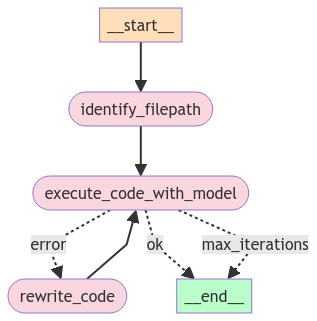

In [10]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
app.invoke({"message": "Please analyze the testscript.py file", "iterations": 1})

RESULT CODE EXECUTION: TypeError("unsupported operand type(s) for +: 'int' and 'str'")
EVALUATION RESULT: content='True' response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 269, 'total_tokens': 271}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-cfd8e8e9-443c-49cd-a816-22eab701c2f5-0'
Error in testscript.py. 1 tries done
NEW SUGGESTED CODE: x = 2
y = "test"
print(str(x) + y)
RESULT CODE EXECUTION: 2test

EVALUATION RESULT: content='False' response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 261, 'total_tokens': 263}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-9da5c826-9d64-40ee-be44-d4c38af84ace-0'
Code was probably fixed... check out testscript.py if it is correct


{'message': 'Please analyze the testscript.py file',
 'error': 'False',
 'error_message': 'Executed:\n```python\nx = 2\ny = "test"\nprint(str(x) + y)\n```\nStdout: 2test\n',
 'file_path': 'testscript.py',
 'code': 'x = 2\ny = "test"\nprint(str(x) + y)',
 'iterations': 2}